# Transfer Learning from Supervised and Self-Supervised Pretraining using PyTorch Lightning

- toc: true
- category: blog
- tags: pytorch-lightning transfer-learning supervised-learning self-supervised-learning

Credit to original author William Falcon, and also to Alfredo Canziani for posting the video presentation: [_Supervised and self-supervised transfer learning (with PyTorch Lightning)_](https://www.youtube.com/watch?v=nCq_vy9qE-k)

In the video presentation, they compare transfer learning from pretrained:
* supervised
* self-supervised

However, I would like to point out that the comparison is not entirely fair for the case of supervised pretraining. The reason is that they do not replace the last fully-connected layer of the supervised pretrained backbone model with the new finetuning layer. Instead, they stack the new finetuning layer on top of the pretrained model (including its last fully connected layer).

This is a clear disadvantage for the supervised pretrained model because:
* all its expressive power is contained in the output of the penultimate layer
* and it was already used by the last fully-connected layer to predict 1,000 classes

When stacking the finetuning layer on top of it, this has to perform the 10-class classification using the output of the 1,000-class classfication layer.

On the contrary, if we replace the backbone last fully connected layer with the new finetuning layer, it will be able to perform the 10-class classification using all the expressive power of the features coming from the output of the penultimate layer.

In this notebook I show that if we replace the last fully connected layer with the new finetuning layer, both supervised and self-supervised approaches give comparable results.

In [ ]:
%%capture
!pip install pytorch-lightning
!pip install pytorch-lightning-bolts==0.2.5rc1

In [ ]:
import pytorch_lightning as pl
import pl_bolts

print(f"pl version: {pl.__version__}")
print(f"pl_bolts version: {pl_bolts.__version__}")

pl version: 1.0.6
pl_bolts version: 0.2.5rc1


In [ ]:
import torch
from torchvision import models

resnet50 = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
from torchvision.datasets import CIFAR10
from torchvision import transforms

normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                 std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

cf10_transforms = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

cifar_10 = CIFAR10('.', train=True, download=True, transform=cf10_transforms)

Extracting ./cifar-10-python.tar.gz to .


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


LABEL: 6



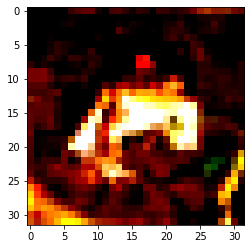

In [ ]:
from matplotlib import pyplot as plt

image, label = next(iter(cifar_10))
print(f"LABEL: {label}")
plt_img = image.numpy().transpose(1, 2, 0)
plt.imshow(plt_img);

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(cifar_10, batch_size=32, shuffle=True)

In [ ]:
for batch in train_loader:
    x, y = batch
    print(x.shape, y.shape)
    break

torch.Size([32, 3, 32, 32]) torch.Size([32])


In [ ]:
import torch
from torchvision import models

resnet50 = models.resnet50(pretrained=True)

for param in resnet50.parameters():
    param.requires_grad = False

num_classes = 10
resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, num_classes)

# Use afterwards in optimizer: resnet50.fc.parameters()

In [ ]:
x, y = next(iter(train_loader))

preds = resnet50(x)
preds[:5]

tensor([[-0.3801, -0.5696,  0.6141, -0.0555, -0.0337, -0.0064,  0.6410,  0.5071,
          0.5621, -0.3443],
        [ 0.8296, -0.8653,  0.4210, -0.1691,  0.4789, -0.6263,  1.6198,  0.1962,
          1.6246, -0.7211],
        [-0.2604,  0.1539,  0.4095, -0.1340, -0.0187, -0.2622,  0.5658,  0.2214,
          0.6504, -0.0676],
        [ 0.2170,  0.0293,  0.1628,  0.3194, -0.0261, -0.3643,  0.0667,  0.0840,
          0.2994, -0.4926],
        [ 0.5270, -0.7288, -0.4667,  0.3634,  0.4815,  0.3479,  1.4035,  0.4295,
          0.3564, -0.1770]], grad_fn=<SliceBackward>)

In [ ]:
from torch.nn.functional import softmax

preds = softmax(preds, dim=-1)
preds[:5]

tensor([[0.0569, 0.0470, 0.1537, 0.0787, 0.0804, 0.0826, 0.1579, 0.1381, 0.1459,
         0.0589],
        [0.1203, 0.0221, 0.0799, 0.0443, 0.0847, 0.0280, 0.2650, 0.0638, 0.2663,
         0.0255],
        [0.0646, 0.0978, 0.1263, 0.0733, 0.0823, 0.0645, 0.1476, 0.1046, 0.1606,
         0.0784],
        [0.1171, 0.0970, 0.1109, 0.1297, 0.0918, 0.0655, 0.1007, 0.1025, 0.1271,
         0.0576],
        [0.1118, 0.0318, 0.0414, 0.0949, 0.1068, 0.0935, 0.2687, 0.1014, 0.0943,
         0.0553]], grad_fn=<SliceBackward>)

In [ ]:
pred_labels = torch.argmax(preds, dim=-1)
pred_labels[:5]

tensor([6, 8, 8, 3, 6])

In [ ]:
y[:5]

tensor([6, 9, 1, 8, 8])

In [ ]:
#  Bolts: Data Module: 3 data loaders

from pl_bolts.datamodules import CIFAR10DataModule

dm = CIFAR10DataModule('.')

## Supervised Pretraining

### Fitting only the new finetuning layer

In [ ]:
# # PyTorch

# from torch.nn.functional import cross_entropy
# from torch.optim import Adam

# optimizer = Adam(resnet50.fc.parameters(), lr=1e-3)

# epochs = 10
# for epoch in range(epochs):
#     for batch in dm.train_dataloader():
#         x, y = batch

#         # features = backbone(x)
#         # # disable gradients to backbone if all parameters used by the optimizer
#         # features = features.detach()

#         # # tell PyTorch not to track the computational graph: much faster, less memory used: not backpropagated
#         # with torch.no_grad():
#         #     features = backbone(x)

#         # preds = finetune_layer(features)

#         preds = resnet50(x)

#         loss = cross_entropy(preds, y)

#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()

In [ ]:
# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy

from torch.nn.functional import cross_entropy
from torch.optim import Adam

class ImageClassifier(pl.LightningModule):
    def __init__(self, num_classes=10, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        # self.num_classes = num_classes
        # self.lr = lr

        self.model = models.resnet50(pretrained=True)

        for param in self.model.parameters():
            param.requires_grad = False

        self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_classes)

    def training_step(self, batch, batch_idx):
        # return the loss given a batch: this has a computational graph attached to it: optimization
        x, y = batch
        preds = self.model(x)
        loss = cross_entropy(preds, y)
        self.log('train_loss', loss)  # lightning detaches your loss graph and uses its value
        self.log('train_acc', accuracy(preds, y))
        return loss

    def configure_optimizers(self):
        # return optimizer
        optimizer = Adam(self.model.fc.parameters(), lr=self.hparams.lr)
        return optimizer

In [ ]:
classifier = ImageClassifier()

trainer = pl.Trainer(progress_bar_refresh_rate=20, gpus=1, max_epochs=2)  # for Colab: set refresh rate to 20 instead of 10 to avoid freezing
trainer.fit(classifier, dm)  # train_loader

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)


Files already downloaded and verified
Files already downloaded and verified



  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 23 M  


1

In [ ]:
# Start tensorboard
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/

<IPython.core.display.Javascript object>

![](img/20201117-1-train_acc.svg "Train Accuracy")

![](img/20201117-1-train_loss.svg "Train Loss")

### Fitting all the model after 10 epochs

In [ ]:
# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy

from torch.nn.functional import cross_entropy
from torch.optim import Adam

class ImageClassifier(pl.LightningModule):
    def __init__(self, num_classes=10, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        # self.num_classes = num_classes
        # self.lr = lr

        self.model = models.resnet50(pretrained=True)

        for param in self.model.parameters():
            param.requires_grad = False

        self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_classes)

    def training_step(self, batch, batch_idx):
        # return the loss given a batch: this has a computational graph attached to it: optimization
        x, y = batch
        if self.trainer.current_epoch == 10:
            for param in self.model.parameters():
                param.requires_grad = True
        preds = self.model(x)
        loss = cross_entropy(preds, y)
        self.log('train_loss', loss)  # lightning detaches your loss graph and uses its value
        self.log('train_acc', accuracy(preds, y))
        return loss

    def configure_optimizers(self):
        # return optimizer
        optimizer = Adam(self.model.parameters(), lr=self.hparams.lr)  # self.model.fc.parameters()
        return optimizer

In [ ]:
classifier = ImageClassifier()

trainer = pl.Trainer(progress_bar_refresh_rate=5, gpus=1, limit_train_batches=20, max_epochs=20)
trainer.fit(classifier, dm)  # train_loader

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 23 M  


1

In [ ]:
# Start tensorboard
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6006 (pid 327), started 0:01:19 ago. (Use '!kill 327' to kill it.)

<IPython.core.display.Javascript object>

![](img/20201117-2-train_acc.svg "Train Accuracy")

![](img/20201117-2-train_loss.svg "Train Loss")

## Self-Supervised Pretraining

https://pytorch-lightning-bolts.readthedocs.io/en/latest/self_supervised_models.html#swav

### Fitting all the model after 10 epochs

In [ ]:
# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy

from torch.nn.functional import cross_entropy
from torch.optim import Adam

from pl_bolts.models.self_supervised import SwAV
weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/swav/swav_imagenet/swav_imagenet.pth.tar'
swav = SwAV.load_from_checkpoint(weight_path, strict=True)

# from pl_bolts.models.self_supervised import SimCLR
# weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/simclr-cifar10-v1-exp12_87_52/epoch%3D960.ckpt'
# simclr = SimCLR.load_from_checkpoint(weight_path, strict=False)


class ImageClassifier(pl.LightningModule):
    def __init__(self, num_classes=10, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        # self.num_classes = num_classes
        # self.lr = lr

        # self.model = models.resnet50(pretrained=True)
        self.backbone = swav.model
        # self.backbone = simclr

        for param in self.backbone.parameters():
            param.requires_grad = False

        # self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_classes)
        self.finetune_layer = torch.nn.Linear(3000, num_classes)

    def training_step(self, batch, batch_idx):
        # return the loss given a batch: this has a computational graph attached to it: optimization
        x, y = batch
        if self.trainer.current_epoch == 10:
            for param in self.backbone.parameters():
                param.requires_grad = True
        (features1, features2) = self.backbone(x)
        features = features2
        # features = self.backbone(x)
        preds = self.finetune_layer(features)
        loss = cross_entropy(preds, y)
        self.log('train_loss', loss)  # lightning detaches your loss graph and uses its value
        self.log('train_acc', accuracy(preds, y))
        return loss

    def configure_optimizers(self):
        # return optimizer
        optimizer = Adam(self.parameters(), lr=self.hparams.lr)  # self.model.fc.parameters()
        return optimizer

Downloading: "https://pl-bolts-weights.s3.us-east-2.amazonaws.com/swav/swav_imagenet/swav_imagenet.pth.tar" to /root/.cache/torch/hub/checkpoints/swav_imagenet.pth.tar


In [ ]:
classifier = ImageClassifier()

trainer = pl.Trainer(progress_bar_refresh_rate=5, gpus=1, limit_train_batches=20, max_epochs=20)
trainer.fit(classifier, dm)  # train_loader

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name           | Type   | Params
------------------------------------------
0 | backbone       | ResNet | 28 M  
1 | finetune_layer | Linear | 30 K  


1

In [ ]:
# Start tensorboard
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6006 (pid 327), started 0:03:19 ago. (Use '!kill 327' to kill it.)

<IPython.core.display.Javascript object>

![](img/20201117-3-train_acc.svg "Train Accuracy")

![](img/20201117-3-train_loss.svg "Train Loss")